<a href="https://colab.research.google.com/github/female-coders-linz/workshops/blob/master/forecasting_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with Prophet

In [0]:
# Install mwviews (needed to access Wikipedia article views data)
from IPython.display import clear_output

!pip install mwviews

clear_output()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from mwviews.api import PageviewsClient
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [0]:
# Load data: page views of wikipedia site
p = PageviewsClient(user_agent="info@female-coders.at Prophet time series forecasting example")

# go back to 20150701
article_views = p.article_views('en.wikipedia', ['Wolfgang Amadeus Mozart', 'Austria'], granularity='monthly', start='20150701', end='20200430' )
df_article_views = pd.DataFrame(article_views).T.sort_index()
df_article_views.head()

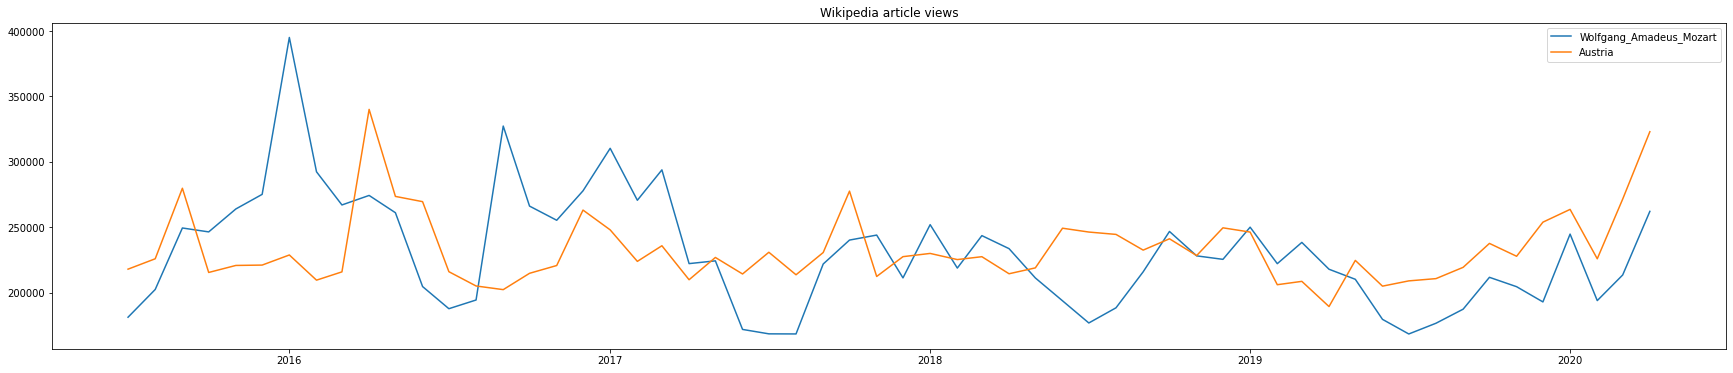

In [167]:
# First view on the data

fig = plt.figure(figsize=(30, 6))
plt.plot(df_article_views)
plt.legend(df_article_views.columns)
plt.title('Wikipedia article views')
plt.show()

## Prepare dataframe

In [0]:
# let's use Wolfgang Amadeus Mozart 
# input data needs column ds (time) and y 
df_input = pd.DataFrame({ 
    'ds': df_article_views.index, 
    'y': df_article_views['Wolfgang_Amadeus_Mozart']
})


In [169]:
# Define what data we want to use for training and test

test_len = 6
train, test = df_input[:-test_len], df_input[-test_len:]

print(f'Training size: {len(train)}')
print(f'Test size: {test_len}')

Training size: 52
Test size: 6


In [186]:
# Fit model

# if you have daily data, you might want to include holidays, 
#    e.g. birthday, Salzburger Festspiele,...

# mozart_birthday = pd.DataFrame({
#   'holiday': 'mozart_birthday',
#   'ds': pd.to_datetime(['2018-01-27', '2019-01-27', '2020-01-27']),
#   'lower_window': 0,
#   'upper_window': 1,
# })

model = Prophet(
      holidays=mozart_birthday, 
      interval_width=0.95, 
      seasonality_prior_scale=0.025
)

model.fit(train)

# if you are more interested in the tech details, have a look at the parameters
# model.params

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OrderedDict([('k', array([[-0.16587158]])),
             ('m', array([[0.67379009]])),
             ('delta',
              array([[-2.00185458e-10, -1.55794351e-09, -3.23453383e-10,
                      -8.19190051e-06,  4.60761135e-10,  3.15485367e-10,
                      -6.98828766e-10, -8.58176592e-10,  3.51059110e-10,
                       4.60036322e-10,  4.59893887e-10, -7.70825300e-11,
                       9.79311948e-10,  1.36229938e-09, -2.98325338e-10,
                      -6.78998697e-11,  1.15639029e-07,  2.12195848e-07,
                       2.19743269e-09,  1.90793204e-09,  4.45114164e-10,
                      -7.50970298e-10, -4.80812040e-10,  1.24631119e-09,
                       1.71214058e-09]])),
             ('sigma_obs', array([[0.05519205]])),
             ('beta',
              array([[ 1.15372492e-03,  8.61414033e-02,  4.64054766e-03,
                      -1.28587945e-02,  4.72296270e-03,  1.76320375e-02,
                      -5.28751165e-03,  6.01

In [187]:
# Create a 'future' dataframe 
df_future = model.make_future_dataframe(periods=test_len, freq = 'M')
df_future.tail()

,ds
53,2019-11-30
54,2019-12-31
55,2020-01-31
56,2020-02-29
57,2020-03-31


In [188]:
# predict the future
df_forecast = model.predict(df_future)
df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,mozart_birthday,mozart_birthday_lower,mozart_birthday_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
53,2019-11-30,198134.688585,163698.042385,248069.115071,198134.679113,198134.697950,8009.778741,8009.778741,8009.778741,0.0,0.0,0.0,0.0,0.0,0.0,8009.778741,8009.778741,8009.778741,0.0,0.0,0.0,206144.467327
54,2019-12-31,196826.500950,208347.264368,299386.052390,196826.483758,196826.518689,57944.424354,57944.424354,57944.424354,0.0,0.0,0.0,0.0,0.0,0.0,57944.424354,57944.424354,57944.424354,0.0,0.0,0.0,254770.925304
55,2020-01-31,195518.313314,166055.673663,248344.262311,195518.287097,195518.340385,12023.886371,12023.886371,12023.886371,0.0,0.0,0.0,0.0,0.0,0.0,12023.886371,12023.886371,12023.886371,0.0,0.0,0.0,207542.199686
56,2020-02-29,194294.524881,177136.599876,261227.740120,194294.490315,194294.561775,24702.306123,24702.306123,24702.306123,0.0,0.0,0.0,0.0,0.0,0.0,24702.306123,24702.306123,24702.306123,0.0,0.0,0.0,218996.831004
57,2020-03-31,192986.337246,157187.523199,237649.357204,192986.289873,192986.387162,5572.354083,5572.354083,5572.354083,0.0,0.0,0.0,0.0,0.0,0.0,5572.354083,5572.354083,5572.354083,0.0,0.0,0.0,198558.691329


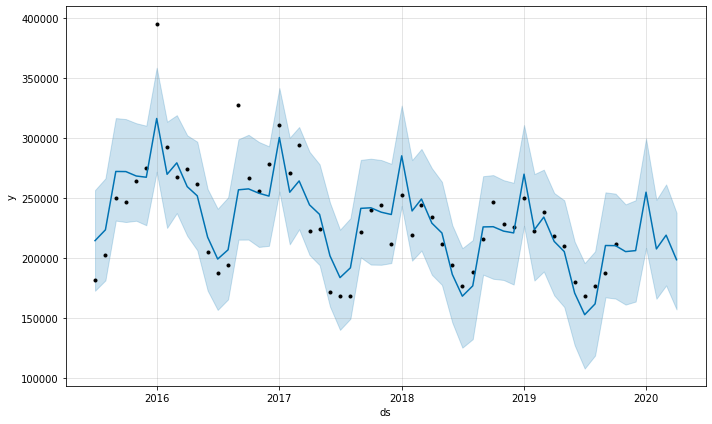

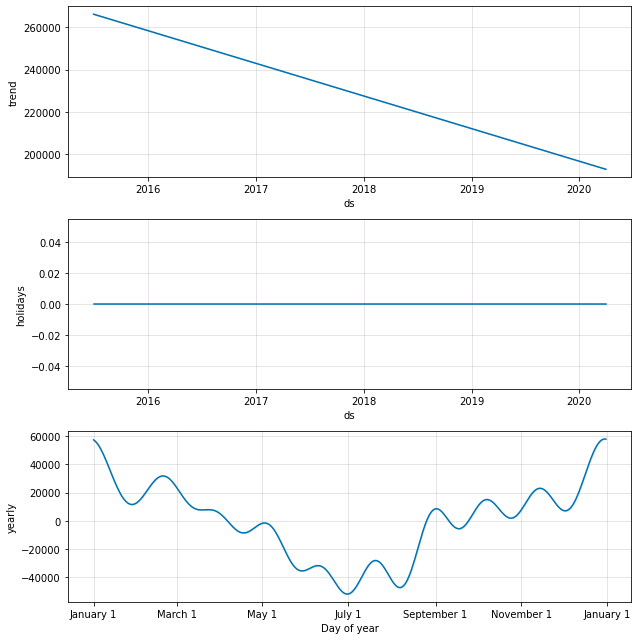

In [189]:
# have a look at your forecast
model.plot(df_forecast).show()

# inspect the model components (trend, saisonalities)
model.plot_components(df_forecast).show()

In [216]:
# How does the forecast dataframe look like? What information can you get out of it?
predicted = df_forecast[-test_len:]
predicted.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,mozart_birthday,mozart_birthday_lower,mozart_birthday_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2019-10-31,199400.676620,161193.964056,244629.571481,199400.673744,199400.679239,5904.024380,5904.024380,5904.024380,0.0,0.0,0.0,0.0,0.0,0.0,5904.024380,5904.024380,5904.024380,0.0,0.0,0.0,205304.701000
53,2019-11-30,198134.688585,163698.042385,248069.115071,198134.679113,198134.697950,8009.778741,8009.778741,8009.778741,0.0,0.0,0.0,0.0,0.0,0.0,8009.778741,8009.778741,8009.778741,0.0,0.0,0.0,206144.467327
54,2019-12-31,196826.500950,208347.264368,299386.052390,196826.483758,196826.518689,57944.424354,57944.424354,57944.424354,0.0,0.0,0.0,0.0,0.0,0.0,57944.424354,57944.424354,57944.424354,0.0,0.0,0.0,254770.925304
55,2020-01-31,195518.313314,166055.673663,248344.262311,195518.287097,195518.340385,12023.886371,12023.886371,12023.886371,0.0,0.0,0.0,0.0,0.0,0.0,12023.886371,12023.886371,12023.886371,0.0,0.0,0.0,207542.199686
56,2020-02-29,194294.524881,177136.599876,261227.740120,194294.490315,194294.561775,24702.306123,24702.306123,24702.306123,0.0,0.0,0.0,0.0,0.0,0.0,24702.306123,24702.306123,24702.306123,0.0,0.0,0.0,218996.831004


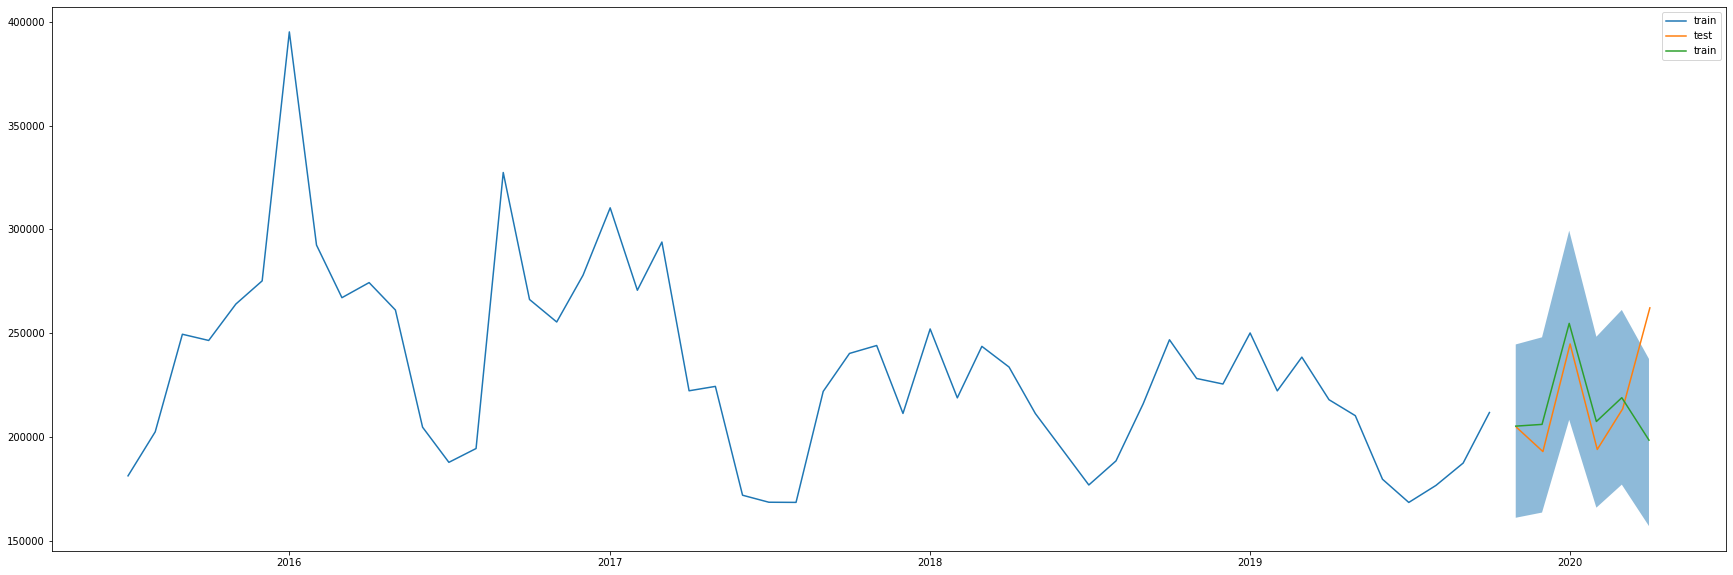

In [192]:
# plot training and test
fig =plt.figure(figsize=(30, 10))
plt.plot(train['ds'], train['y'], label='train')
plt.plot(test['ds'], test['y'], label='test')
plt.plot(predicted['ds'], predicted['yhat'], label='train')
plt.fill_between(predicted['ds'], predicted['yhat_lower'], predicted['yhat_upper'], alpha=0.5)
plt.legend()
plt.show()

In [215]:
# Calculate error metrics

print('Error')
print('---')
print('Train')
print('MAE', mean_absolute_error(y_true=train['y'], y_pred=df_forecast[:-test_len]['yhat']))
print('RMSE', mean_squared_error(y_true=train['y'], y_pred=df_forecast[:-test_len]['yhat'], squared=False))
print('-')
print('Test')
print('MAE', mean_absolute_error(y_true=test['y'], y_pred=predicted['yhat']))
print('RMSE', mean_squared_error(y_true=test['y'], y_pred=predicted['yhat'], squared=False))
print('---')

Error
---
Train
MAE 16262.806885540023
RMSE 21809.86853601254
-
Test
MAE 17683.072165150385
RMSE 27490.76981406775
---
